In [120]:
from mmseg.apis import init_model, inference_model
from mmengine.config import Config
import torch
from cv2 import distanceTransform, DIST_L2, DIST_MASK_PRECISE
import numpy as np

from mmseg.structures.seg_data_sample import SegDataSample
from mmseg.utils.typing_utils import SampleList

In [121]:
nclasses = 3

In [122]:
d = 10

In [123]:
palette = [[0, 0, 0], [255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [64, 64, 64], [128, 128, 0], [128, 0, 128], [0, 128, 128], [255, 128, 0], [192, 192, 192], [128, 128, 128]]

In [124]:
from PIL import Image

In [125]:
# To test
name = 'Stadium_5_Match_2_in_1fps_4281.png'
pred = Image.open('./out_models/segformer/segformer_mit-b4_8xb1-160k_cityscapes-1024x1024.py/tta/' + name)
gt = Image.open('./Dataset/Labels/' + name)

In [126]:
from matplotlib import pyplot as plt

In [127]:
# gt = [[0,0,0,0,0],
#       [0,1,1,1,0],
#       [0,1,0,1,0],
#       [0,1,1,1,0],
#       [0,0,0,0,0]]
# pred = [[0,0,0,0,0],
#         [0,1,1,1,0],
#         [0,1,1,1,0],
#         [0,1,1,1,0],
#         [0,0,0,0,0]]

In [128]:
# # Create a 2d array of size 9*9 with 2 1s horizontal lines in the 3rd and 7th line
# gt = np.zeros((9,9))
# gt[2,:] = 1
# gt[6,:] = 1
# pred = np.zeros((9,9))
# pred[2,:] = 1
# pred[6,:] = 1
# pred

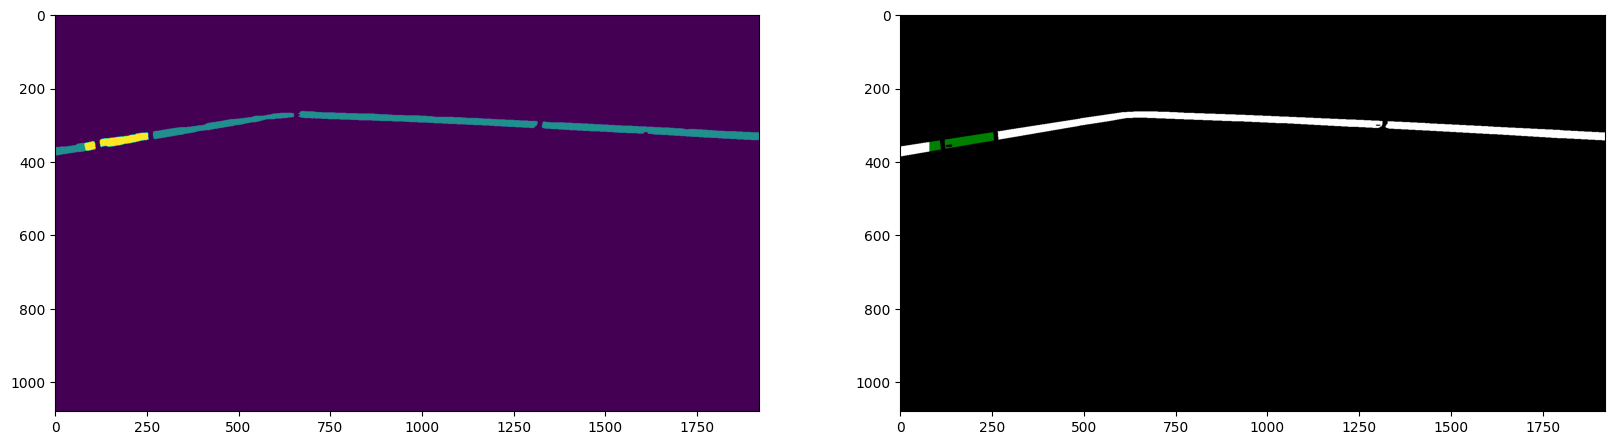

In [129]:
# Show pred and gt
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pred)
plt.subplot(1, 2, 2)
plt.imshow(gt)
plt.show()

In [130]:
# Show the values of a 10x10 square of gt
# Must first convert to numpy array
gt = np.array(gt)
print(gt[180:200, 180:200])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [131]:
# gt = np.array(gt)
gt = torch.tensor(np.array(gt), dtype=torch.int64, device='cuda')
gt

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [132]:
gt_one_hot = torch.nn.functional.one_hot(gt, num_classes=nclasses).permute(2, 0, 1).float()

In [133]:
pred = torch.tensor(np.array(pred), dtype=torch.int64, device='cuda')

In [134]:
pred_one_hot = torch.nn.functional.one_hot(pred, num_classes=nclasses).permute(2, 0, 1).float()
pred_one_hot

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [135]:
# pred_one_hot = torch.tensor([[[0, 0, 0],
#                               [0, 1, 0],
#                               [0, 0, 0]]] * nclasses, dtype=torch.float32, device=pred.device)

In [136]:
kernel = torch.tensor([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]], dtype=torch.float32, device=pred.device)
kernel

tensor([[-1., -1., -1.],
        [-1.,  8., -1.],
        [-1., -1., -1.]], device='cuda:0')

In [137]:
pred_one_hot.unsqueeze(1).shape

torch.Size([3, 1, 1080, 1920])

In [138]:
pred_borders = torch.nn.functional.conv2d(pred_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
pred_borders.shape

torch.Size([3, 1, 1080, 1920])

In [139]:
1-pred_one_hot

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

In [140]:
kernel = torch.tensor([[1, 1, 1],
                       [1, -9, 1],
                       [1, 1, 1]], dtype=torch.float32, device=pred.device)
pred_borders = torch.nn.functional.conv2d(1-pred_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
pred_borders.shape

torch.Size([3, 1, 1080, 1920])

pred_borders and gt_borders stays to float type bc it will be used again in another conv2d

In [141]:
pred_borders = pred_borders.squeeze()
pred_borders.shape

torch.Size([3, 1080, 1920])

In [142]:
pred_borders = pred_borders.clamp(0, 1)
pred_borders

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

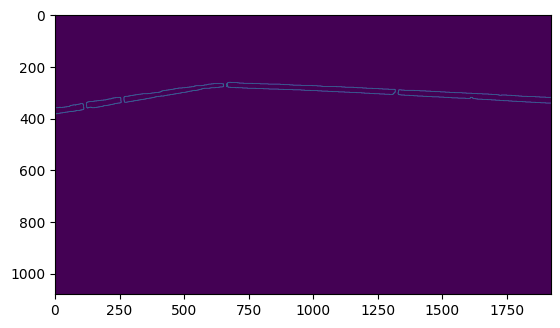

In [143]:
# plot the borders
plt.imshow(pred_borders[0].cpu().numpy())
plt.show()

In [144]:
pred_borders.sum()

tensor(8507., device='cuda:0')

In [145]:
gt_borders = torch.nn.functional.conv2d(gt_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
gt_borders.squeeze_()
gt_borders.shape

torch.Size([3, 1080, 1920])

In [184]:
kernel = torch.tensor([[1, 1, 1],
                       [1, -9, 1],
                       [1, 1, 1]], dtype=torch.float32, device=pred.device)
gt_borders = torch.nn.functional.conv2d(1-gt_one_hot.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
gt_borders.squeeze_()
gt_borders.shape

torch.Size([3, 1080, 1920])

In [185]:
gt_borders.clamp_(0, 1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [186]:
# Image.fromarray(pred_borders[2].cpu().numpy().astype('uint8') * 255, mode='L').save('borders.png')

Compute the mask of pixels at distance d from the contours

In [187]:
d

10

In [188]:
# Create an odd length squared numpy array of ones unless for the pixel in the center that is 0
kernel = np.ones((d*2+1, d*2+1), dtype=np.uint8)
kernel[d, d] = 0
kernel

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [189]:
kernel = distanceTransform(kernel, DIST_L2, DIST_MASK_PRECISE)
kernel

array([[14.142137 , 13.453624 , 12.806249 , 12.206556 , 11.661903 ,
        11.180341 , 10.770329 , 10.440307 , 10.198039 , 10.049875 ,
        10.       , 10.049875 , 10.198039 , 10.440307 , 10.770329 ,
        11.180341 , 11.661903 , 12.206556 , 12.806249 , 13.453624 ,
        14.142137 ],
       [13.453624 , 12.727922 , 12.041595 , 11.401753 , 10.816653 ,
        10.29563  ,  9.848858 ,  9.486834 ,  9.219544 ,  9.055386 ,
         9.       ,  9.055386 ,  9.219544 ,  9.486834 ,  9.848858 ,
        10.29563  , 10.816653 , 11.401753 , 12.041595 , 12.727922 ,
        13.453624 ],
       [12.806249 , 12.041595 , 11.313708 , 10.630146 , 10.       ,
         9.433981 ,  8.944272 ,  8.5440035,  8.246211 ,  8.062258 ,
         8.       ,  8.062258 ,  8.246211 ,  8.5440035,  8.944272 ,
         9.433981 , 10.       , 10.630146 , 11.313708 , 12.041595 ,
        12.806249 ],
       [12.206556 , 11.401753 , 10.630146 ,  9.899495 ,  9.219544 ,
         8.602325 ,  8.062258 ,  7.6157737,  7.280109

In [190]:
kernel = torch.tensor(kernel, dtype=torch.float32, device='cuda')
kernel

tensor([[14.1421, 13.4536, 12.8062, 12.2066, 11.6619, 11.1803, 10.7703, 10.4403,
         10.1980, 10.0499, 10.0000, 10.0499, 10.1980, 10.4403, 10.7703, 11.1803,
         11.6619, 12.2066, 12.8062, 13.4536, 14.1421],
        [13.4536, 12.7279, 12.0416, 11.4018, 10.8167, 10.2956,  9.8489,  9.4868,
          9.2195,  9.0554,  9.0000,  9.0554,  9.2195,  9.4868,  9.8489, 10.2956,
         10.8167, 11.4018, 12.0416, 12.7279, 13.4536],
        [12.8062, 12.0416, 11.3137, 10.6301, 10.0000,  9.4340,  8.9443,  8.5440,
          8.2462,  8.0623,  8.0000,  8.0623,  8.2462,  8.5440,  8.9443,  9.4340,
         10.0000, 10.6301, 11.3137, 12.0416, 12.8062],
        [12.2066, 11.4018, 10.6301,  9.8995,  9.2195,  8.6023,  8.0623,  7.6158,
          7.2801,  7.0711,  7.0000,  7.0711,  7.2801,  7.6158,  8.0623,  8.6023,
          9.2195,  9.8995, 10.6301, 11.4018, 12.2066],
        [11.6619, 10.8167, 10.0000,  9.2195,  8.4853,  7.8103,  7.2111,  6.7082,
          6.3246,  6.0828,  6.0000,  6.0828,  6.324

In [191]:
kernel = kernel <= d
kernel

tensor([[False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False, False, False, False, False,
         False],
        [False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False, False, False,
         False],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  T

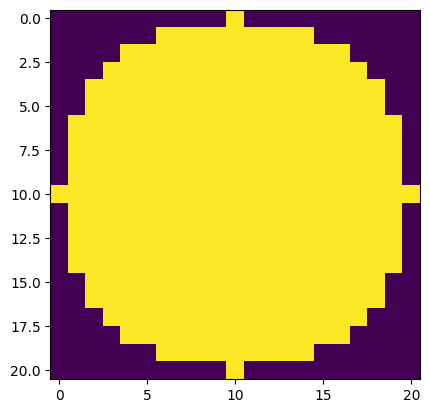

In [192]:
plt.figure()
plt.imshow(kernel.cpu().int().numpy())
plt.show()

In [193]:
kernel = kernel.float()
kernel

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [194]:
pred_d_border = torch.nn.functional.conv2d(pred_borders.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same')
pred_d_border

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [195]:
pred_d_border = pred_d_border.squeeze()
pred_d_border.shape

torch.Size([3, 1080, 1920])

In [196]:
pred_d_border = pred_d_border.clamp(0, 1)
pred_d_border

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [197]:
pred_d_border.sum()

tensor(152839., device='cuda:0')

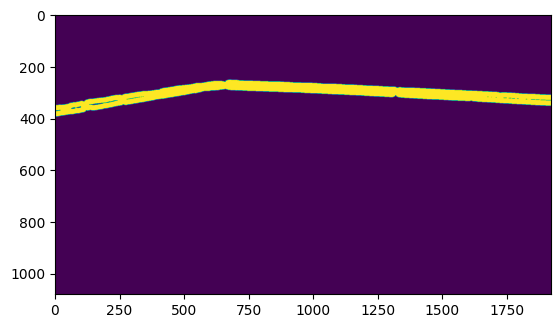

In [198]:
# plot pred_d_borders[1]
plt.figure()
plt.imshow(pred_d_border[0].cpu().numpy())
plt.show()

In [199]:
gt_d_border = torch.nn.functional.conv2d(gt_borders.unsqueeze(1), kernel.unsqueeze(0).unsqueeze(0), padding='same').squeeze().clamp(0, 1)

In [200]:
# Image.fromarray(pred_d_border[1].cpu().numpy().astype('uint8') * 255, mode='L').save('d1borders.png')

In [201]:
pred_one_hot.shape

torch.Size([3, 1080, 1920])

In [202]:
pred_d_border.shape

torch.Size([3, 1080, 1920])

In [203]:
pred_intersections = torch.logical_and(pred_one_hot, pred_d_border)

In [204]:
pred_intersections

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [205]:
# Image.fromarray(pred_intersections[2].cpu().numpy().astype('uint8') * 255, mode='L').save('d1borders2.png')

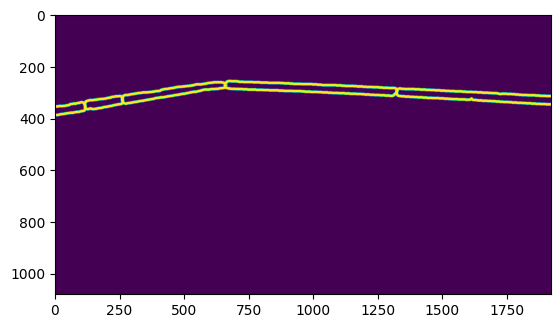

In [206]:
plt.figure()
plt.imshow(pred_intersections[0].cpu().numpy())
plt.show()

In [207]:
gt_intersections = torch.logical_and(gt_one_hot, gt_d_border)
gt_intersections

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

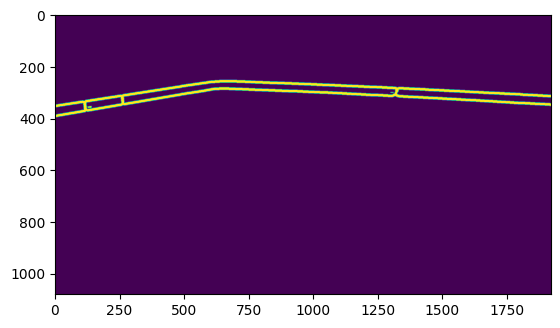

In [208]:
plt.figure()
plt.imshow(gt_intersections[0].cpu().numpy())
plt.show()

In [209]:
# Sum pred_intersections and gt_intersections on the first axis
pred_intersections.sum(axis=(1,2)), gt_intersections.sum(axis=(1,2))

(tensor([43499, 31386,  3481], device='cuda:0'),
 tensor([43456, 34193,  3682], device='cuda:0'))

In [210]:
# Numerator of the BIoU
pred_intersections.logical_and(gt_intersections)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [211]:
numerator = torch.sum(pred_intersections.logical_and(gt_intersections), axis=(1,2))
numerator

tensor([39723, 30942,  3229], device='cuda:0')

In [212]:
# Denominator of the BIoU
pred_intersections.logical_or(gt_intersections)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [213]:
denominator = torch.sum(pred_intersections.logical_or(gt_intersections), axis=(1,2))
denominator

tensor([47232, 34637,  3934], device='cuda:0')

In [214]:
numerator / denominator

tensor([0.8410, 0.8933, 0.8208], device='cuda:0')

In [215]:
gt_intersections

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [216]:
plt_gt_intersections = torch.cat([gt_intersections.int(), torch.ones_like(gt_intersections[0]).unsqueeze(0)])
plt_gt_intersections = plt_gt_intersections.argmax(dim=0).cpu().numpy()
plt_gt_intersections

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [217]:
pred_intersections

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [218]:
plt_pred_intersections = torch.cat([pred_intersections.int(), torch.ones_like(pred_intersections[0]).unsqueeze(0)])
plt_pred_intersections = plt_pred_intersections.argmax(dim=0).cpu().numpy()
plt_pred_intersections

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

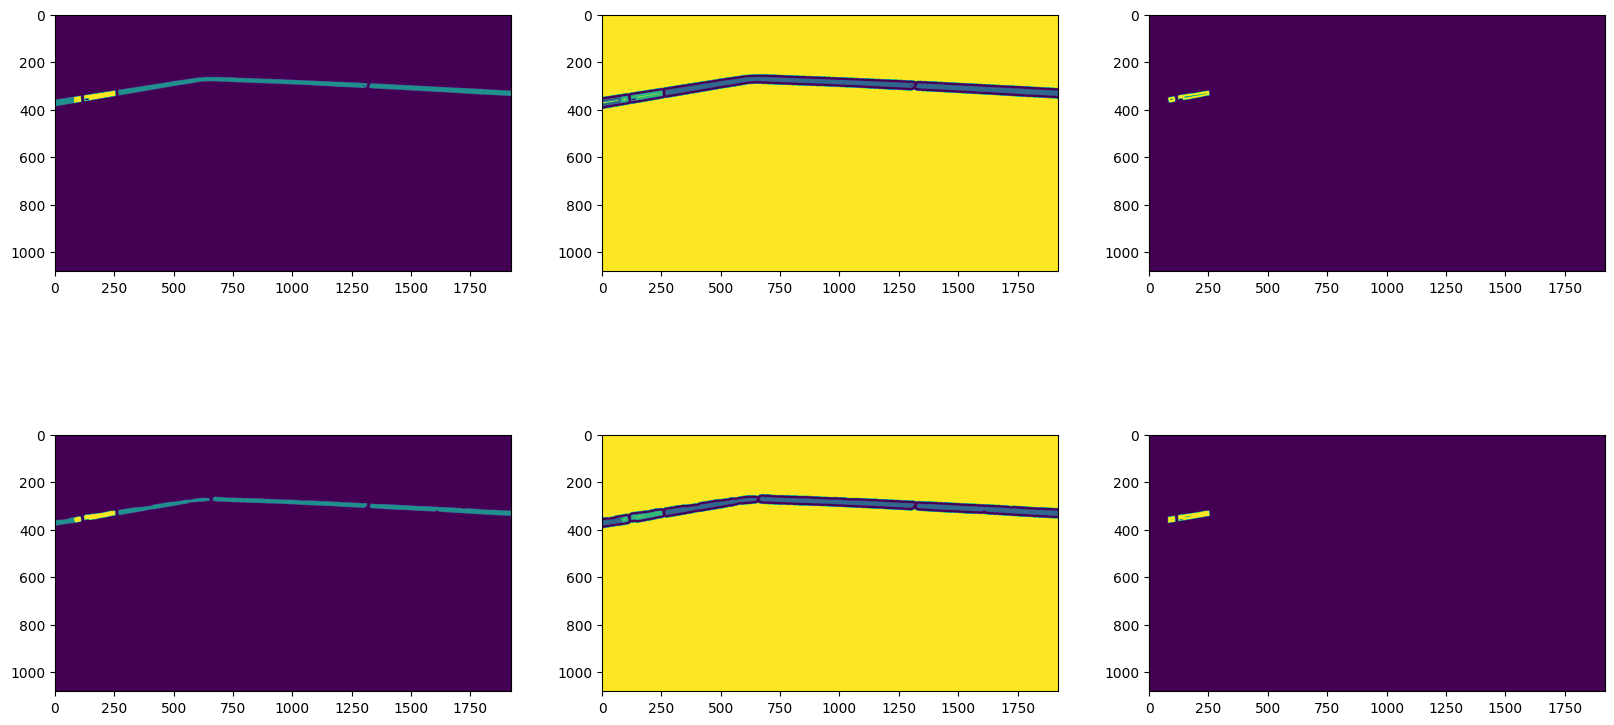

In [219]:
# Using matplotlib draw 6 figures organized in 2 rows and 3 columns
# From left to right and top to bottom show the following images:
# gt, plt_gt_intersections, pred_intersections.logical_and(gt_intersections), pred, plt_pred_intersections, pred_intersections.logical_or(gt_intersections)

# Show pred and gt
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.imshow(gt.cpu().numpy())
plt.subplot(2, 3, 2)
plt.imshow(plt_gt_intersections)
plt.subplot(2, 3, 3)
plt.imshow((pred_intersections.logical_and(gt_intersections))[2].cpu().numpy())
plt.subplot(2, 3, 4)
plt.imshow(pred.cpu().numpy())
plt.subplot(2, 3, 5)
plt.imshow(plt_pred_intersections)
plt.subplot(2, 3, 6)
plt.imshow((pred_intersections.logical_or(gt_intersections))[2].cpu().numpy())
plt.savefig('borders.png', dpi=600)
plt.show()